<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/Buckley_Leverett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水-油置換問題（Buckley-Leverettによる解法）

Version 2.01 (Sep. 2019)

油で満たされている多孔質媒体に対し，水を圧入し水攻する場合を考える．このとき，下記の条件のもと，解析的に解く手法を，Buckley-Leverettの解法という．

- 一次元
- 非圧縮
- 非混和


**参考文献:**

*   Buckley S and Leverett M, *Mechanism of Fluid Displacement in Sands*, 1941.
*   Welge H, *A Simplified Method for Computing Oil Recovery by Gas or Water Drive*, 1952.


## ライブラリのインポート

In [0]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

## 流体の設定

In [0]:
class Fluid:
    def __init__(self, viscosity):
        self.viscosity = viscosity

water = Fluid(viscosity=0.5)
oil = Fluid(viscosity=10)

## 相対浸透率モデル

ここでは，Coreyタイプの相対浸透率モデルを使用することにする．水の相対浸透率 $k_{rw}$ は下記のとおりモデル化される．

$$
k_{rw} = k_{rw,0} \left( \frac{S_w - S_{wc}}{1 - S_{wc} - S_{or}} \right) ^ {n_w} 
$$

ここで，$k_{rw, 0}$ はエンドポイントの水相対浸透率，$S_{wc}$ は connate water saturation，$S_{or}$ は残留油飽和率，$n_w$ は.形状パラメータである．

同様に，油の相対浸透率 $k_{ro}$ は以下のとおりモデル化される．

$$
k_{ro} = k_{ro,0} \left( \frac{S_o - S_{or}}{1 - S_{wc} - S_{or}} \right) ^ {n_o}
$$

ここで， $k_{ro, 0}$ はエンドポイント油相対浸透率，$n_o$ は形状パラメータである．

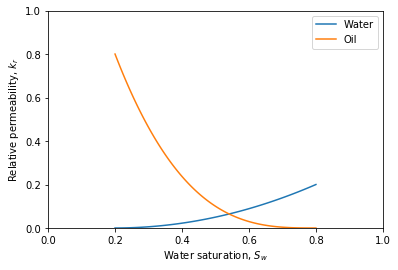

In [0]:
Swc = 0.2 # Connate water saturation
Sor = 0.2 # Residual oil saturation

# Saturation
Sw = np.linspace(start=Swc, stop=1-Sor, num = 100) # Water
So = 1- Sw # Oil

# Normalized saturation
Swn = np.linspace(start=0, stop=1, num = 100) # Water
Son = 1- Swn # Oil

# Relative permeability
def relperm(Sn, kr0, n):
    kr = kr0 * Sn ** n
    return kr

krw = relperm(Sn=Swn, kr0=0.2, n=2) # Water
kro = relperm(Sn=Son, kr0=0.8, n=3) # Oil

# Plotting
plt.plot(Sw, krw, label='Water')
plt.plot(Sw, kro, label='Oil')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Relative permeability, $k_r$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## フラクショナルフロー

Assuming that capillary pressure is negligible, fractional flow of water, $f_w$ can be expressed as follows;

$$
f_w = \frac{\lambda_w}{\lambda_t} \left( 1 - k_{ro} N_g  \sin \theta \right)
$$

where $\lambda_w$ and $\lambda_t$ are water and total mobilities, respectively, $N_g$ is gravity number, and $\theta$ is dip angle. $\lambda_w$ and $\lambda_o$ and $\lambda_t$  are expressed as follows;

$$
\lambda_w = \frac{k \ k_{rw}}{\mu_w}
$$

$$
\lambda_o = \frac{k \ k_{ro}}{\mu_o}
$$

$$
\lambda_t = \lambda_w + \lambda_o
$$

and $N_g$ is expressed as;

$$
N_g = \frac{\left( k / \mu_o \right) \Delta \rho g}{u_t}
$$

where $k$ is absolute permeability, $\Delta \rho$ is difference in fluid density ($\Delta \rho = \rho_w - \rho_o$), and $g$ is gravitational acceleration. 

In [0]:
k = 10 # d, Absolute permeability
drho = 0.2 # g/cm3, Difference in density 
g = 9.8 # m/s2, Gravitational acceleration
ut = 0.1 # ft/day, Total volumetric flow velocity

Ng = (k / oil.viscosity) * drho * g / ut  *0.283 # 0.283 is a unit conversion factor 
# 1 md = 1e-12 m2
# 1 g/cm3 = 1e3 kg/m3
# 1 cP = 1e-3 kg/m-s
# 1 ft/day = 3.5278e-6 m/s

print('Absolute permeability: {0:.2f} d'.format(k))
print('Viscosity of oil: {0:.2f} cP'.format(oil.viscosity))
print('Difference in fluid density: {0:.3f} g/cm3'.format(drho))
print('Total volumetric flow velocity: {0:.3f} ft/day'.format(ut))
print()
print('Gravity number: {0:.3f}'.format(Ng))

Absolute permeability: 10.00 d
Viscosity of oil: 10.00 cP
Difference in fluid density: 0.200 g/cm3
Total volumetric flow velocity: 0.100 ft/day

Gravity number: 5.547


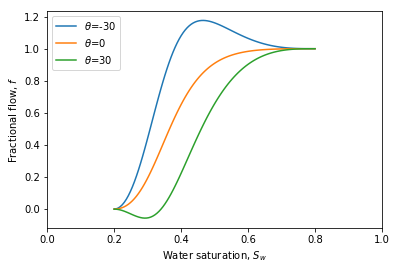

In [0]:
# Mobility
lw = k * krw / water.viscosity # Water
lo = k * kro / oil.viscosity # Oil
lt = lw + lo # Total

# Fractional flow
for theta in  [-30, 0 , 30]:
    fw = lw / lt * (1 - kro * Ng * np.sin(np.deg2rad(theta) ))
    plt.plot(Sw, fw, label='$\\theta$='+str(theta))

plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow, $f$')
plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.show()

Assuming that the gravity is negligible as well, $f_w$ can be expressed as follows;

$$
f_w = \frac{\lambda_w}{\lambda_t} = \frac{1}{1+ \frac{k_{ro}}{ \mu_{o}} / \frac{k_{rw} }{ \mu_{w}}}
$$

where $\mu_o$ is oil viscosity, and $\mu_w$ is water viscosity.

For the following discussions, it is assumed that both capillary pressure and gravity are negligible.

In [0]:
 fw = lw / lt

## Bucklery-Leverett theory

Buckley and Leverett (1941) showed following equation.

$$\frac{df_w}{dS_w} = \frac{dx_D}{dt_D} = v_D $$

where $x_D$ is dimensionless distance, $t_D$ is dimensionless time and $v_D$ is dimensionless velocity of specific saturation.

$$x_D = \frac{x}{L}$$

$$t_D = \int_0^t \frac{u}{\phi L} dt = \frac{qt}{V_p}$$

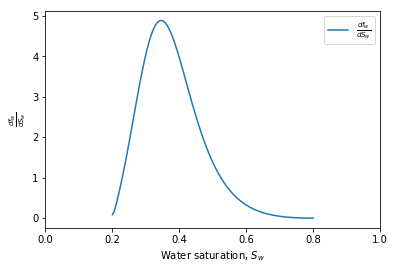

In [0]:
# Derivative of fractional flow of water
dfw = np.gradient(fw, Sw)

# Plot
plt.plot(Sw, dfw, label='$\\frac{df_w}{dS_w}$')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('$\\frac{df_w}{dS_w}$')
plt.xlim(0, 1)
# plt.ylim(0,)
plt.show()

## Shock Front

Based on Welge (1952).



*   **Velocity consraint:** Wave velocities in the two phase region must decrease monotonically for zones in which compositions vary continuously as the solution composition path is traced from down stream compositions to upstream compositions.
*   **Entropy condition:** Wave velocities on the upstream side of the shock must be greater than (or equal to) the shock velocity and wave velocities on the down stream side must be less than (or equal to) the shock velocity.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.



Dimensionless Shock Front velocity: 3.299
Shock Front water saturation: 0.424


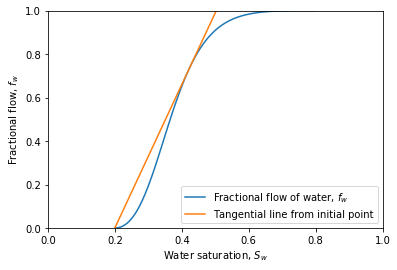

In [0]:
slope_fw = (fw - 0) / (Sw - Swc)  # Warning: slope_fw[0] = nan

vD_sf = np.nanmax(slope_fw) # Shock Front velocity
Sw_sf = Sw[np.nanargmax(slope_fw)] # Shock Front water saturation

print()
print('Dimensionless Shock Front velocity: {0:.3f}'.format(vD_sf))
print('Shock Front water saturation: {0:.3f}'.format(Sw_sf))

# Plot
plt.plot(Sw, fw, label='Fractional flow of water, $f_w$')
plt.plot(Sw, vD_sf*(Sw - Swc) , label='Tangential line from initial point')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow, $f_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

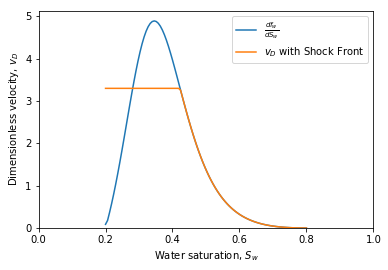

In [0]:
# Dimensionless velocity with Shock Front
vD = np.array([vD_sf if s < Sw_sf else df for s, df in zip(Sw, dfw)])

# Plot
plt.plot(Sw, dfw, label='$\\frac{df_w}{dS_w}$')
plt.plot(Sw, vD, label='$v_D$ with Shock Front')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Dimensionless velocity, $v_D$')
plt.xlim(0, 1)
plt.ylim(0,)
plt.show()

## Saturation profiles

$$x_D (S_w) = v_D (S_w) \times t_D$$

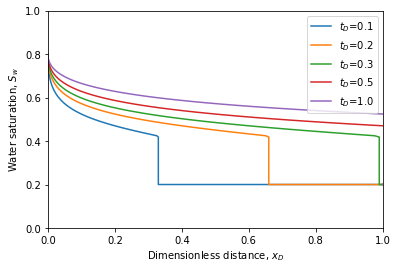

In [0]:
for tD in [0.1, 0.2, 0.3, 0.5, 1.0]:
    xD = vD * tD
    plt.plot([1, *xD], [Swc, *Sw], label='$t_D$='+str(tD))

plt.xlabel('Dimensionless distance, $x_D$')
plt.ylabel('Water saturation, $S_w$')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Profiles

In [0]:
# Dimensionless time for plotting
tD = np.linspace(start=0, stop=2, num = 100)

### Breakthrough time

Dimensionless time at breakthrough, $t_{D, BT} $ [PV] can be expressed as follows;

$$ t_{D, BT} = \frac{1}{v_{D, sf}}$$

In [0]:
tD_BT = 1/vD_sf
print('Dimensionless time at Breakthrough: {0:.3f}'.format(tD_BT))

Dimensionless time at Breakthrough: 0.303


### Average water saturation

Average water saturation at whole region, $\bar{S_w}$ can be expressed as follows;

$$
\bar{S_w} =
        \begin{cases}
            S_{wc} + t_D \quad \quad  \quad t_D \le t_{D, BT}  \\
            S_{w, out} - \frac{f_{w, out} - 1}{f'_{w, out} }  \quad otherwise \\
        \end{cases}
$$

where $S_{w, out}$ is water saturation at outlet, $f_{w, out}$ is fractional flow of water at outlet, and $f'_{w, out}$ is derivative of fractional flow of water at outlet.

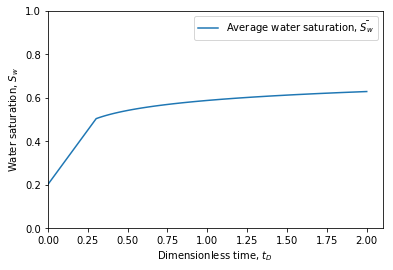

In [0]:
# Water saturation at outlet
f = interpolate.interp1d(vD, Sw, kind='linear')
Sw_out =  np.array([Swc if tDi < tD_BT else  f(1/tDi) for tDi in tD])

# Fractional flow of water at outlet
f = interpolate.interp1d(vD, fw, kind='linear')
fw_out =  np.array([0 if tDi < tD_BT else  f(1/tDi) for tDi in tD])

# Average water saturation at whole region
Sw_ave = np.array([Swc + tD[i] if tD[i] < tD_BT else Sw_out[i] - (fw_out[i] - 1) / (1/tD[i]) for i in range(len(tD))])

# Plot
plt.plot(tD, Sw_ave, label='Average water saturation, $\\bar{S_w}$')
plt.legend()
plt.xlabel('Dimensionless time, $t_D$')
plt.ylabel('Water saturation, $S_w$')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

### Oil recovery volume

Oil recovery volume, $N$ [PV] can be expressed as follows;

$$
N =
        \begin{cases}
            t_{D} \quad \quad t_D \le t_{D, BT}  \\
            \bar{S_w} - S_{wc}  \quad otherwise \\
        \end{cases}
$$

At breakthrough;

$$N_{BT} =  t_{D, BT} $$

Oil recovery volume at Breakthrough: 0.303 PV


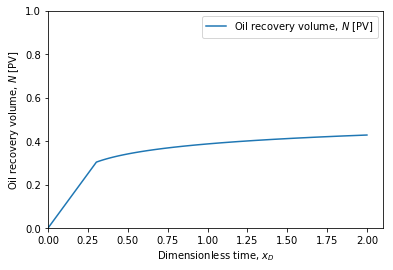

In [0]:
N = np.array([tD[i] if tD[i] < tD_BT else Sw_ave[i] - Swc for i in range(len(tD))])

N_BT = tD_BT
print('Oil recovery volume at Breakthrough: {0:.3f} PV'.format(N_BT))

# Plot
plt.plot(tD, N, label='Oil recovery volume, $N$ [PV]')
plt.legend()
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery volume, $N$ [PV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

### Oil recovery factor

Oil recovery factor, $RF$ [HCPV] can be expressed as follows;

$$
{RF} = \frac{N}{1-S_{wc}}
$$

At breakthough,

$$
{RF}_{BT} = \frac{N_{BT}}{1-S_{wc}}
$$

Oil recovery factor at Breakthrough: 0.379 HCPV


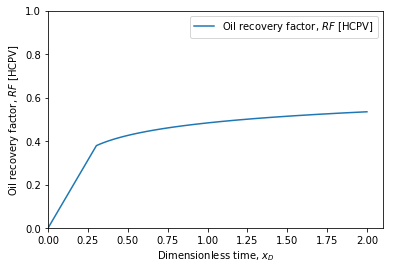

In [0]:
RF = N / (1 - Swc)

RF_BT = N_BT / (1 - Swc) 
print('Oil recovery factor at Breakthrough: {0:.3f} HCPV'.format(RF_BT))

# Plot
plt.plot(tD, RF, label='Oil recovery factor, $RF$ [HCPV]')
plt.legend()
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery factor, $RF$ [HCPV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

*End of notebook...*